# IMPORT LIBRARIES

In [1]:
import numpy 
import pandas 
import keras 
import tensorflow as tf 
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline 

# LOAD DATASET

In [2]:
df = pd.read_csv('RSCCASN.csv', index_col= 'DATE', parse_dates= True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ['Sales']

## VISUALIZATION

<AxesSubplot:xlabel='DATE'>

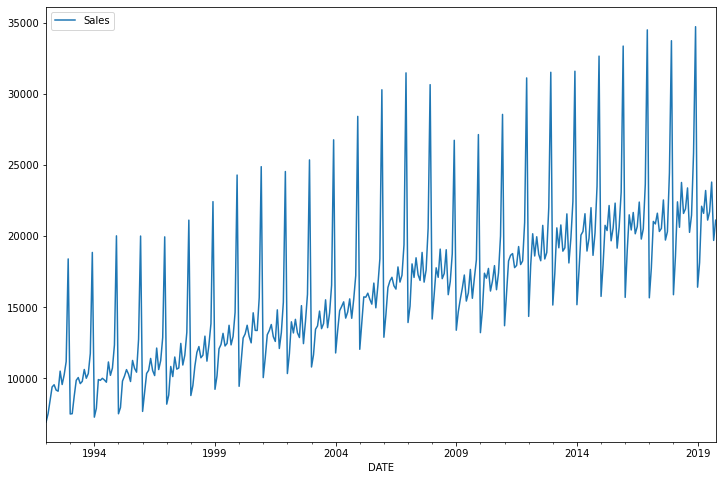

In [5]:
df.plot(figsize = (12,8))

# TRAIN TEST SPLIT

In [6]:
len(df)

334

In [7]:
df.shape

(334, 1)

Data is monthly, let's forecast 1.5 years into the future.

In [8]:
len(df) - 18

316

In [9]:
test_size = 18

In [10]:
test_ind = len(df) - test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train 

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test 

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## SCALING DATA

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [17]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# TIME SERIES GENERATOR

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [20]:
# What does the first batch look like?
X,y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


# BUILDING MODEL

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
# We're only using one feature in our time series
n_features = 1

In [24]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


## EARLYSTOPPING AND CREATING A VALIDATION GENERATOTR

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience= 2)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

## TRAIN MODEL

In [29]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator,callbacks=[early_stop])

C:\Users\sony\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 3s 5ms/step - loss: 0.0231 - val_loss: 0.0031
Epoch 2/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0142 - val_loss: 0.0952
Epoch 3/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0083 - val_loss: 3.9221e-04
Epoch 4/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 5/20
304/304 [==============================] - 1s 5ms/step - loss: 0.0026 - val_loss: 0.0031


## LOSS CALCULATION

In [30]:
losses = pd.DataFrame(model.history.history)

In [31]:
losses

,loss,val_loss
0,0.023123,0.003080
1,0.014209,0.095158
2,0.008275,0.000392
3,0.005424,0.004352
4,0.002550,0.003076


## VISUALIZATION

<AxesSubplot:>

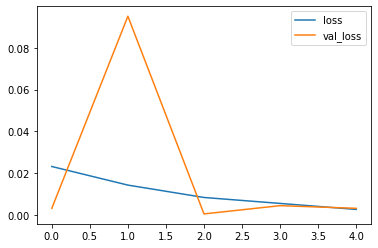

In [32]:
losses.plot()

## EVALUATE ON TEST DATA

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## INVERSE TRANSFORMATION AND COMPARE

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

<ipython-input-35-53e06c23926f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [36]:
test 

,Sales,Predictions
DATE,,
2018-05-01,23764,22538.506003
2018-06-01,21589,21615.840673
2018-07-01,21919,21846.557489
2018-08-01,23381,23410.150659
2018-09-01,20260,21296.771420
2018-10-01,21473,21861.568013
2018-11-01,25831,25364.615031
2018-12-01,34706,34970.666987
2019-01-01,16410,18146.085889


## VISUALIZATION

<AxesSubplot:xlabel='DATE'>

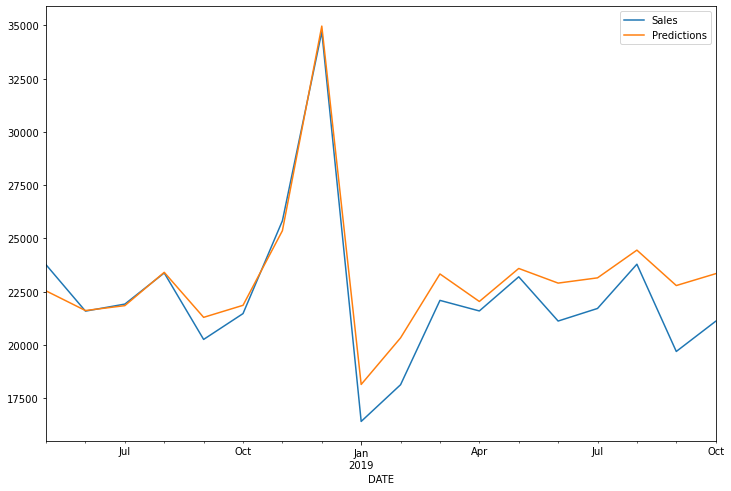

In [37]:
test.plot(figsize=(12,8))

# RETRAIN AND FORECASTING

## RESCALING ON FULL DATA

In [38]:
full_scaler = MinMaxScaler()

## RETRAINING ON FULL DATA

In [39]:
scaled_full_data = full_scaler.fit_transform(df)

In [40]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

## REMODELING

In [41]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

### RETRAINING

In [42]:
model.fit_generator(generator, epochs=8)

C:\Users\sony\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 3s 5ms/step - loss: 0.0272
Epoch 2/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0165
Epoch 3/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0077
Epoch 4/8
322/322 [==============================] - 1s 5ms/step - loss: 0.0034
Epoch 5/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0021
Epoch 6/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 7/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0014
Epoch 8/8
322/322 [==============================] - 2s 5ms/step - loss: 0.0013


## FORECASTING

In [43]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [44]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [45]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [46]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [47]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [48]:
forecast_df

,Forecast
2019-11-01,27502.096806
2019-12-01,40117.626527
2020-01-01,17650.311764
2020-02-01,19206.865108
2020-03-01,23130.233868
2020-04-01,22619.629813
2020-05-01,24420.439488
2020-06-01,22365.368655
2020-07-01,22943.199103
2020-08-01,25218.637158


## VISUALIZATION

<AxesSubplot:>

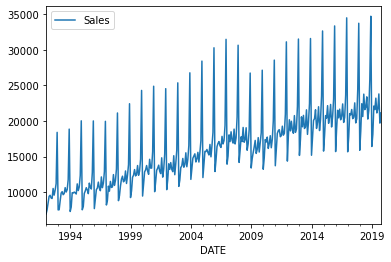

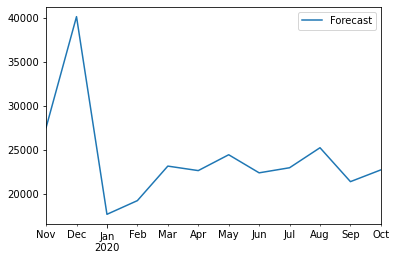

In [49]:
df.plot()
forecast_df.plot()

### JOINING PANDAS VISUALIZATION

<AxesSubplot:xlabel='DATE'>

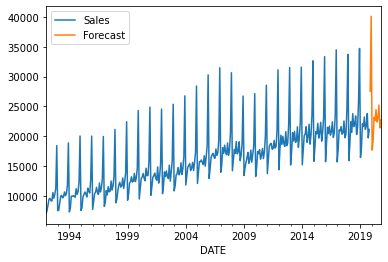

In [50]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

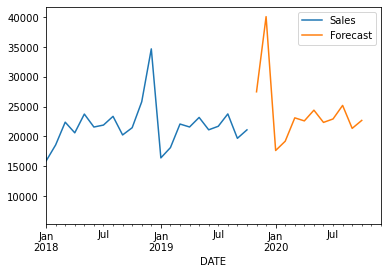

In [51]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# GREAT JOB!